In [2]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
from sklearn.metrics import classification_report

import torch

from monai.apps import download_and_extract
from monai.config import print_config
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import *
from monai.data import Dataset, DataLoader
from monai.utils import set_determinism

#print_config()

In [3]:
data_dir = '../input/gujarati-ocr-typed-gujarati-characters/Gujarati/Train' 
test_dir='../input/gujarati-ocr-typed-gujarati-characters/Gujarati/Test'

class_names0 = os.listdir(data_dir)
class_names=sorted(class_names0)

num_class = len(class_names)
image_files = [[os.path.join(data_dir, class_name, x) 
               for x in os.listdir(os.path.join(data_dir, class_name))] 
               for class_name in class_names]

timage_files = [[os.path.join(test_dir, class_name, x) 
               for x in os.listdir(os.path.join(test_dir, class_name))] 
               for class_name in class_names]

In [4]:
image_file_list = []
image_label_list = []
for i, class_name in enumerate(class_names):
    image_file_list.extend(image_files[i])
    image_label_list.extend([i] * len(image_files[i]))
num_total = len(image_label_list)

In [5]:
timage_file_list = []
timage_label_list = []
for i, class_name in enumerate(class_names):
    timage_file_list.extend(timage_files[i])
    timage_label_list.extend([i] * len(timage_files[i]))
tnum_total = len(timage_label_list)

In [6]:
image_width, image_height = Image.open(image_file_list[0]).size

print('Total image count:', num_total)
print("Image dimensions:", image_width, "x", image_height)
print("Label names:", class_names)
print("Label counts:", [len(image_files[i]) for i in range(num_class)])

Total image count: 53043
Image dimensions: 32 x 32
Label names: ['A', 'AA', 'Ai', 'Ala', 'Alaa', 'Alai', 'Alam', 'Alau', 'Ale', 'Alee', 'Ali', 'Alo', 'Aloo', 'Alu', 'Am', 'Ana', 'Anaa', 'Anai', 'Anam', 'Anau', 'Ane', 'Anee', 'Ani', 'Ano', 'Anoo', 'Anu', 'Au', 'Ba', 'Baa', 'Bai', 'Bam', 'Bau', 'Be', 'Bee', 'Bha', 'Bhaa', 'Bhai', 'Bham', 'Bhau', 'Bhe', 'Bhee', 'Bhi', 'Bho', 'Bhoo', 'Bhu', 'Bi', 'Bo', 'Boo', 'Bu', 'Cha', 'Chaa', 'Chai', 'Cham', 'Chau', 'Che', 'Chee', 'Chha', 'Chhaa', 'Chhai', 'Chham', 'Chhau', 'Chhe', 'Chhee', 'Chhi', 'Chho', 'Chhoo', 'Chhu', 'Chi', 'Cho', 'Choo', 'Chu', 'DDO', 'DDa', 'DDaa', 'DDai', 'DDam', 'DDau', 'DDe', 'DDee', 'DDha', 'DDhaa', 'DDhai', 'DDham', 'DDhau', 'DDhe', 'DDhee', 'DDhi', 'DDho', 'DDhoo', 'DDhu', 'DDi', 'DDoo', 'DDu', 'Da', 'Daa', 'Dai', 'Dam', 'Dau', 'De', 'Dee', 'Dha', 'Dhaa', 'Dhai', 'Dham', 'Dhau', 'Dhe', 'Dhee', 'Dhi', 'Dho', 'Dhoo', 'Dhu', 'Di', 'Do', 'Doo', 'Du', 'E', 'EE', 'Ga', 'Gaa', 'Gai', 'Gam', 'Gau', 'Ge', 'Gee', 'Gha', 'Ghaa', 'Gh

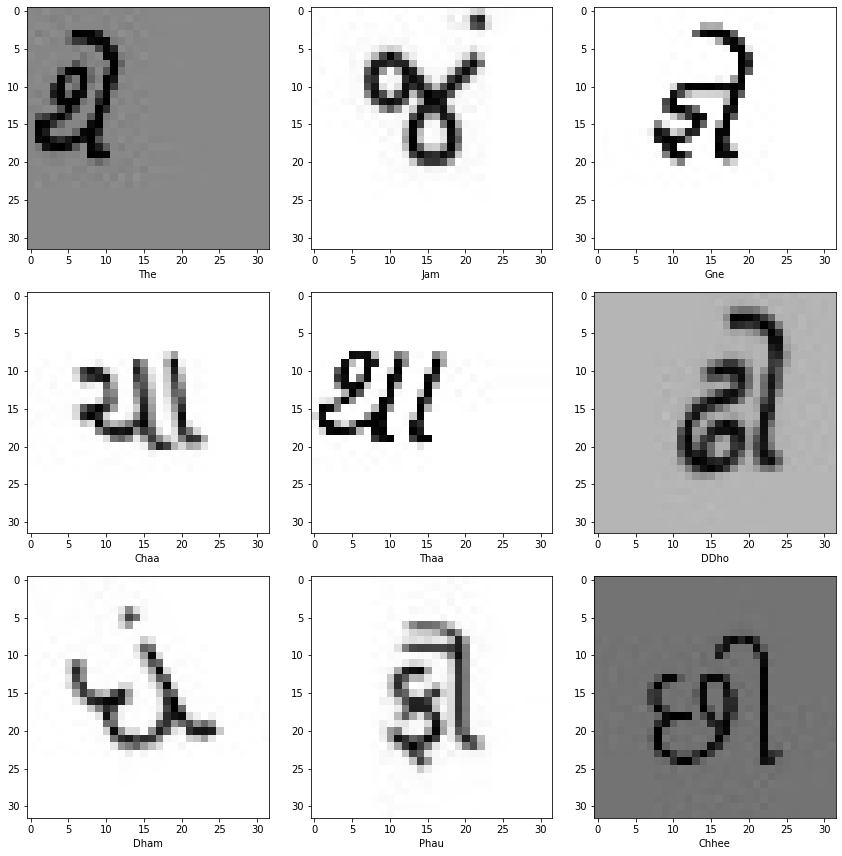

In [7]:
plt.subplots(3,3, figsize=(12,12))
for i,k in enumerate(np.random.randint(num_total, size=9)):
    im = Image.open(image_file_list[k])
    arr = np.array(im)
    plt.subplot(3,3, i+1)
    plt.xlabel(class_names[image_label_list[k]])
    plt.imshow(arr, cmap='gray', vmin=0, vmax=255)
plt.tight_layout()
plt.show()

In [8]:
valid_frac = 0.1
trainX,trainY = [],[]
valX,valY = [],[]
for i in range(num_total):
    rann = np.random.random()
    if rann < valid_frac:
        valX.append(image_file_list[i])
        valY.append(image_label_list[i])
    else:
        trainX.append(image_file_list[i])
        trainY.append(image_label_list[i])

print(len(trainX),len(valX))

47784 5259


In [9]:
testX,testY = [],[] 
for i in range(tnum_total):   
    testX.append(timage_file_list[i])
    testY.append(timage_label_list[i])
    
print(len(testX))

23100


In [10]:
trainX=np.array(trainX)
trainY=np.array(trainY)
valX=np.array(valX)
valY=np.array(valY)
testX=np.array(testX)
testY=np.array(testY)

In [11]:
class SumDimension(Transform):
    def __init__(self, dim=1):
        self.dim = dim

    def __call__(self, inputs):
        return inputs.sum(self.dim)

In [12]:
class Astype(Transform):
    def __init__(self, type='uint8'):
        self.type = type
    def __call__(self, inputs):
        return inputs.astype(self.type)

In [13]:
train_transforms = Compose([
    LoadImage(image_only=True),
    SumDimension(2),    
    NormalizeIntensity(),
    Astype(),
    #ScaleIntensity(),
    #Astype(),
    #RandRotate(range_x=10, prob=0.2, keep_size=True),
    #RandFlip(spatial_axis=0, prob=0.5),
    #RandZoom(min_zoom=1.0, max_zoom=1.1, prob=0.3, keep_size=True),
    AddChannel(),
    ToTensor(),
])

val_transforms = Compose([
    LoadImage(image_only=True),
    SumDimension(2),    
    NormalizeIntensity(),
    Astype(),
    #ScaleIntensity(),
    #Astype(),    
    AddChannel(),
    ToTensor(),
])

act = Activations(softmax=True)
to_onehot = AsDiscrete(to_onehot=num_class, n_classes=num_class)

In [14]:
class MedNISTDataset(Dataset):

    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]

In [15]:
train_ds = MedNISTDataset(trainX, trainY, train_transforms)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2)

val_ds = MedNISTDataset(valX, valY, val_transforms)
val_loader = DataLoader(val_ds, batch_size=64, num_workers=2)

test_ds = MedNISTDataset(testX, testY, val_transforms)
test_loader = DataLoader(test_ds, batch_size=64, num_workers=2)

In [16]:
device = torch.device("cuda:0")   #"cuda:0",cpu
model = DenseNet121(
    spatial_dims=2,            
    in_channels=1,
    out_channels=num_class,
).to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
epoch_num = 10    ###10
val_interval = 1

In [17]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
auc_metric = ROCAUCMetric()
metric_values = list()

for epoch in range(epoch_num):
    print('-' * 10)
    print(f"epoch {epoch + 1}/{epoch_num}")
    model.train()
    epoch_loss = 0
    step = 0

    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs.float())     ##### .float()
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                y_pred = torch.cat([y_pred, model(val_images.float())], dim=0)    ##### .float()
                y = torch.cat([y, val_labels], dim=0)
                
            y_onehot = [to_onehot(i) for i in y]
            y_pred_act = [act(i) for i in y_pred]
            auc_metric(y_pred_act, y_onehot)
            auc_result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(auc_result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            
            if acc_metric > best_metric:
                best_metric = acc_metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), 'best_metric_model.pth')
                print('saved new best metric model')
                
            print(f"current epoch: {epoch + 1} current AUC: {auc_result:.4f}"
                  f" current accuracy: {acc_metric:.4f} best AUC: {best_metric:.4f}"
                  f" at epoch: {best_metric_epoch}")
            
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")


----------
epoch 1/10
1/746, train_loss: 6.0603
2/746, train_loss: 6.1291
3/746, train_loss: 5.9983
4/746, train_loss: 6.0627
5/746, train_loss: 6.0921
6/746, train_loss: 6.1052
7/746, train_loss: 6.0104
8/746, train_loss: 5.9854
9/746, train_loss: 6.0830
10/746, train_loss: 6.0876
11/746, train_loss: 6.0204
12/746, train_loss: 5.9963
13/746, train_loss: 6.0077
14/746, train_loss: 6.0821
15/746, train_loss: 6.0268
16/746, train_loss: 6.0383
17/746, train_loss: 6.0224
18/746, train_loss: 6.1084
19/746, train_loss: 5.9377
20/746, train_loss: 6.1153
21/746, train_loss: 6.0469
22/746, train_loss: 5.9970
23/746, train_loss: 6.0822
24/746, train_loss: 6.0901
25/746, train_loss: 6.0556
26/746, train_loss: 5.9842
27/746, train_loss: 6.1187
28/746, train_loss: 6.0213
29/746, train_loss: 6.0626
30/746, train_loss: 5.9831
31/746, train_loss: 5.9247
32/746, train_loss: 5.9630
33/746, train_loss: 6.0433
34/746, train_loss: 5.9952
35/746, train_loss: 5.9545
36/746, train_loss: 5.9767
37/746, train_l

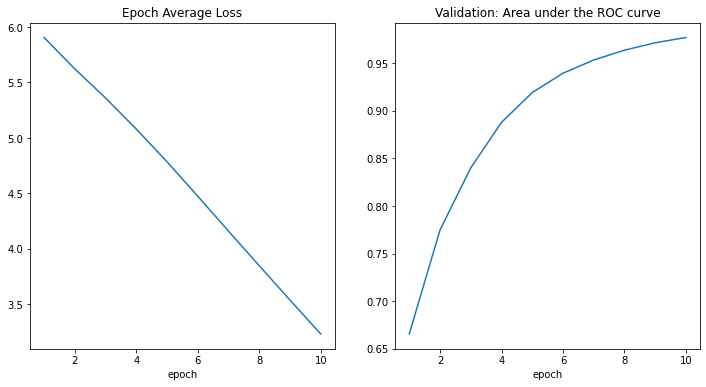

In [18]:
plt.figure('train', (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel('epoch')
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Validation: Area under the ROC curve")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel('epoch')
plt.plot(x, y)
plt.show()

In [19]:
model.load_state_dict(torch.load('best_metric_model.pth'))
model.eval()
y_true = list()
y_pred = list()

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        pred = model(test_images.float()).argmax(dim=1)   ##### .float()
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

In [20]:
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

           A     0.3387    0.7000    0.4565        60
          AA     0.3643    0.8500    0.5100        60
          Ai     0.6000    0.5500    0.5739        60
         Ala     0.6406    0.6833    0.6613        60
        Alaa     0.4301    0.6667    0.5229        60
        Alai     0.7429    0.4333    0.5474        60
        Alam     1.0000    0.1500    0.2609        60
        Alau     0.5000    0.4333    0.4643        60
         Ale     0.7308    0.3167    0.4419        60
        Alee     0.6379    0.6167    0.6271        60
         Ali     0.4242    0.4667    0.4444        60
         Alo     0.4615    0.3000    0.3636        60
        Aloo     0.7429    0.4333    0.5474        60
         Alu     0.4306    0.5167    0.4697        60
          Am     0.7255    0.6167    0.6667        60
         Ana     0.5385    0.8167    0.6490        60
        Anaa     0.5357    0.5000    0.5172        60
        Anai     0.7273    

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
